# **Import required libraries** (Импорт необходимых библиотек)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy.stats as stats      # Для автоматизации тестирвоания гипотез распределений


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

import os
pwd = "/kaggle/input/playground-series-s4e10"
path_train = os.path.join(pwd, "train.csv")
path_test = os.path.join(pwd, "test.csv")
path_submission = os.path.join(pwd, "sample_submission.csv")

# **Import Data and Data Quality analysis**

## **Load DataFrame** (Загрузка данных)

In [2]:
df_train = pd.read_csv(path_train).drop("id", axis=1)
target_col = 'loan_status'
numeric_columns = list(df_train.describe().columns)

## **Initial data inspection** (Первичный осмотр данных)

Просмотр первых и последних строк данных

In [3]:
df_train.head(4)

person_age  person_income person_home_ownership  person_emp_length  \
0          37          35000                  RENT                0.0   
1          22          56000                   OWN                6.0   
2          29          28800                   OWN                8.0   
3          30          70000                  RENT               14.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
0                         N                          14            0  
1                         N                           2            0  
2                         N                          10            0  
3                         N                           5            0

In [4]:
df_train.tail(4)

person_age  person_income person_home_ownership  person_emp_length  \
58641          28          28800                  RENT                0.0   
58642          23          44000                  RENT                7.0   
58643          22          30000                  RENT                2.0   
58644          31          75000              MORTGAGE                2.0   

      loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
58641     MEDICAL          C      10000          12.73                 0.35   
58642   EDUCATION          D       6800          16.00                 0.15   
58643   EDUCATION          A       5000           8.90                 0.17   
58644     VENTURE          B      15000          11.11                 0.20   

      cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
58641                         N                           8            1  
58642                         N                           2            1  
58643                         N                           3            0  
58644                         N                           5            0

Получение общей информации о выборке данных

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.4+ MB


DataFrame metadata desctiption (Описание полей набора данных)

The dataset includes key borrower attributes and loan parameters that are used to analyze and build models to predict the probability of default. Each record represents a specific borrower and its profile, allowing machine learning models to identify patterns and risk factors.
(Набор данных включает ключевые атрибуты заемщиков и параметры кредитов, которые используются для анализа и построения моделей предсказания вероятности дефолта. Каждая запись представляет конкретного заемщика и его профиль, что позволяет моделям машинного обучения выявлять закономерности и факторы риска)

- 1   **person_age**                  (int64)  -- Возраст заявителя в годах. Отражает количество полных лет на момент подачи заявки на кредит.
- 2   **person_income**               (int64)  -- Годовой доход заявителя в денежных единицах (например, в долларах США). Показывает суммарный доход до вычета налогов и других обязательных платежей.
- 3   **person_home_ownership**       (object) -- Статус владения жильем заявителя. Это категориальная переменная, которая может принимать значения:
   - 'RENT' — арендует жилье;
   - 'OWN' — полностью владеет жильем;
   - 'MORTGAGE' — жилье находится в ипотеке;
   - 'OTHER' — другой тип владения или проживания.
- 4   **person_emp_length**           (float64) -- Стаж работы заявителя в годах. Может содержать дробные значения для точного отражения продолжительности занятости (например, 5.5 лет).
- 5   **loan_intent**                 (object) -- Цель или назначение кредита. Категориальная переменная со значениями:
   - 'PERSONAL' — личные нужды;
   - 'EDUCATION' — оплата образования;
   - 'MEDICAL' — медицинские расходы;
   - 'VENTURE' — инвестиции в бизнес;
   - 'HOMEIMPROVEMENT' — ремонт или улучшение жилья;
   - 'DEBTCONSOLIDATION' — консолидация задолженностей.
- 6   **loan_grade**                  (object) -- Кредитный рейтинг заявки, присвоенный финансовым учреждением. Обозначается буквами от 'A' до 'G', где 'A' — наивысший рейтинг (низкий риск), а 'G' — самый низкий (высокий риск).
- 7   **loan_amnt**                   (int64)  -- Запрошенная сумма кредита в денежных единицах.
- 8   **loan_int_rate**               (float64) -- Процентная ставка по кредиту в процентах. Отражает стоимость кредита для заемщика.
- 9   **loan_percent_income**         (float64) -- Отношение запрошенной суммы кредита к годовому доходу заявителя, выраженное в виде десятичной дроби или процента. Показывает, какую долю дохода составляет сумма кредита (например, 0.15 означает, что сумма кредита составляет 15% годового дохода).
- 10  **cb_person_default_on_file**   (object) -- Наличие у заявителя истории дефолтов, зарегистрированных в кредитном бюро. Принимает значения:
    - 'Y' — есть запись о прежнем дефолте;
    - 'N' — отсутствует запись о дефолте.
- 11  **cb_person_cred_hist_length**  (int64)  -- Длина кредитной истории заявителя в годах, отражает продолжительность активности в кредитных отношениях.
- 12  **loan_status**                 (int64) -- Целевая переменная для модели бинарной классификации. Указывает статус кредита:
    - 0 — заемщик не допустил дефолта (кредит погашается своевременно);
    - 1 — заемщик допустил дефолт (неспособность выполнять обязательства по кредиту).

Статистическое описание числовых признаков

In [6]:
df_train.describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  58645.000000   5.864500e+04       58645.000000  58645.000000   
mean      27.550857   6.404617e+04           4.701015   9217.556518   
std        6.033216   3.793111e+04           3.959784   5563.807384   
min       20.000000   4.200000e+03           0.000000    500.000000   
25%       23.000000   4.200000e+04           2.000000   5000.000000   
50%       26.000000   5.800000e+04           4.000000   8000.000000   
75%       30.000000   7.560000e+04           7.000000  12000.000000   
max      123.000000   1.900000e+06         123.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count   58645.000000         58645.000000                58645.000000   
mean       10.677874             0.159238                    5.813556   
std         3.034697             0.091692                    4.029196   
min         5.420000             0.000000                    2.000000   
25%         7.880000             0.090000                    3.000000   
50%        10.750000             0.140000                    4.000000   
75%        12.990000             0.210000                    8.000000   
max        23.220000             0.830000                   30.000000   

        loan_status  
count  58645.000000  
mean       0.142382  
std        0.349445  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

Выводы по набору данных:


**Возраст заемщиков**

- Средний возраст: 27.55 лет.
- Медианный возраст: 26 лет.
- Интерквартильный размах (25% — 75%): 23 — 30 лет.
- Минимальный возраст: 20 лет.
- Максимальный возраст: 123 года — значение явно аномальное и может указывать на ошибку в данных.

**Годовой доход заемщиков**
- Средний доход: 64,046 денежных единиц.
- Медианный доход: 58,000 денежных единиц.
- Интерквартильный размах: 42,000 — 75,600 денежных единиц.
- Минимальный доход: 4,200 денежных единиц.
- Максимальный доход: 1,900,000 денежных единиц — возможный выброс.

**Стаж работы заемщиков**
- Средний стаж: 4.7 лет.
- Медианный стаж: 4 года.
- Интерквартильный размах: 2 — 7 лет.
- Минимальный стаж: 0 лет.
- Максимальный стаж: 123 года — что является нереалистичным и требует проверки.

**Суммы кредитов**
- Средняя сумма кредита: 9,217.56 денежных единиц.
- Медианная сумма кредита: 8,000 денежных единиц.
- Интерквартильный размах суммы кредита: 5,000 — 12,000 денежных единиц.
- Минимальная сумма кредита: 500 денежных единиц.
- Максимальная сумма кредита: 35,000 денежных единиц.

**Процентная ставка**
- Средняя процентная ставка: 10.68%.
- Медианная процентная ставка: 10.75%.
- Интерквартильный размах процентной ставки: 7.88% — 12.99%.
- Минимальная процентная ставка: 5.42%.
- Максимальная процентная ставка: 23.22%.

**Отношение суммы кредита к доходу**
- Среднее отношение: 15.92%.
- Медианное отношение: 14%.
- Интерквартильный размах: 9% — 21%.
- Максимальное отношение: 83%.

**Длина кредитной истории**
- Средняя длина истории: 5.81 лет.
- Медианная длина истории: 4 года.
- Интерквартильный размах: 3 — 8 лет.
- Минимальная длина истории: 2 года.
- Максимальная длина истории: 30 лет.

**Выводы**
- Молодая аудитория -- большинство заемщиков — молодые люди в возрасте от 23 до 30 лет.
- Разнообразие доходов -- широкий диапазон доходов указывает на то, что кредитами пользуются как низко-, так и высокодоходные группы.
- Высокое стандартное отклонение (37,931 денежных единиц) указывает на существенную вариативность доходов.
- Относительно низкий опыт работы -- большинство заемщиков имеют стаж работы от 2 до 7 лет, что коррелирует с их молодым возрастом.
- Суммы кредитов -- большинство заемщиков запрашивают суммы от 5,000 до 12,000 денежных единиц, что может соответствовать потребительским нуждам или небольшим инвестициям.
- Процентные ставки -- основная масса кредитов выдается под ставки от 7.88% до 12.99%, что может отражать среднерыночные условия.
- Умеренная кредитная нагрузка -- в среднем заемщики берут кредиты, сумма которых составляет около 16% их годового дохода.

**Для предобработки данных**
- Аномалии в данных -- возраст в 123 года нереалистичен и свидетельствует о необходимости очистки данных от выбросов.
- Необходимо проверить данные на выбросы, особенно в верхнем диапазоне доходов.
- Аномалии данных -- значение стажа в 123 года требует проверки и, вероятно, удаления из набора данных.
- Высокие значения отношения (до 83%) могут указывать на повышенный риск и требуют дополнительного анализа кредитоспособности.



## **Checking missing values** (Проверка на пропущенные значения)

Подсчет пропущенных значений в каждом столбце

In [7]:
df_train.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

Визуализация пропущенных значений

In [8]:
df_train.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

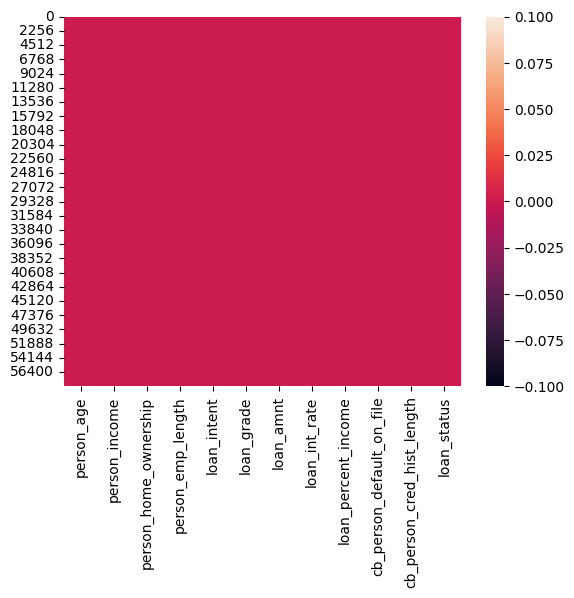

In [9]:
sns.heatmap(df_train.isnull(), cbar=True)
plt.show()

## **Checking duplicates** (Проверка на дубликаты)

Подсчет числа строк с дубликатами

In [10]:
duplicates = df_train.duplicated()
print(duplicates.sum())

0


## **Anomaly analysis** (Анализ статистических выбросов)

### Визуализация парных графиков для визуального осмотра нулей

<Figure size 819.2x614.4 with 0 Axes>

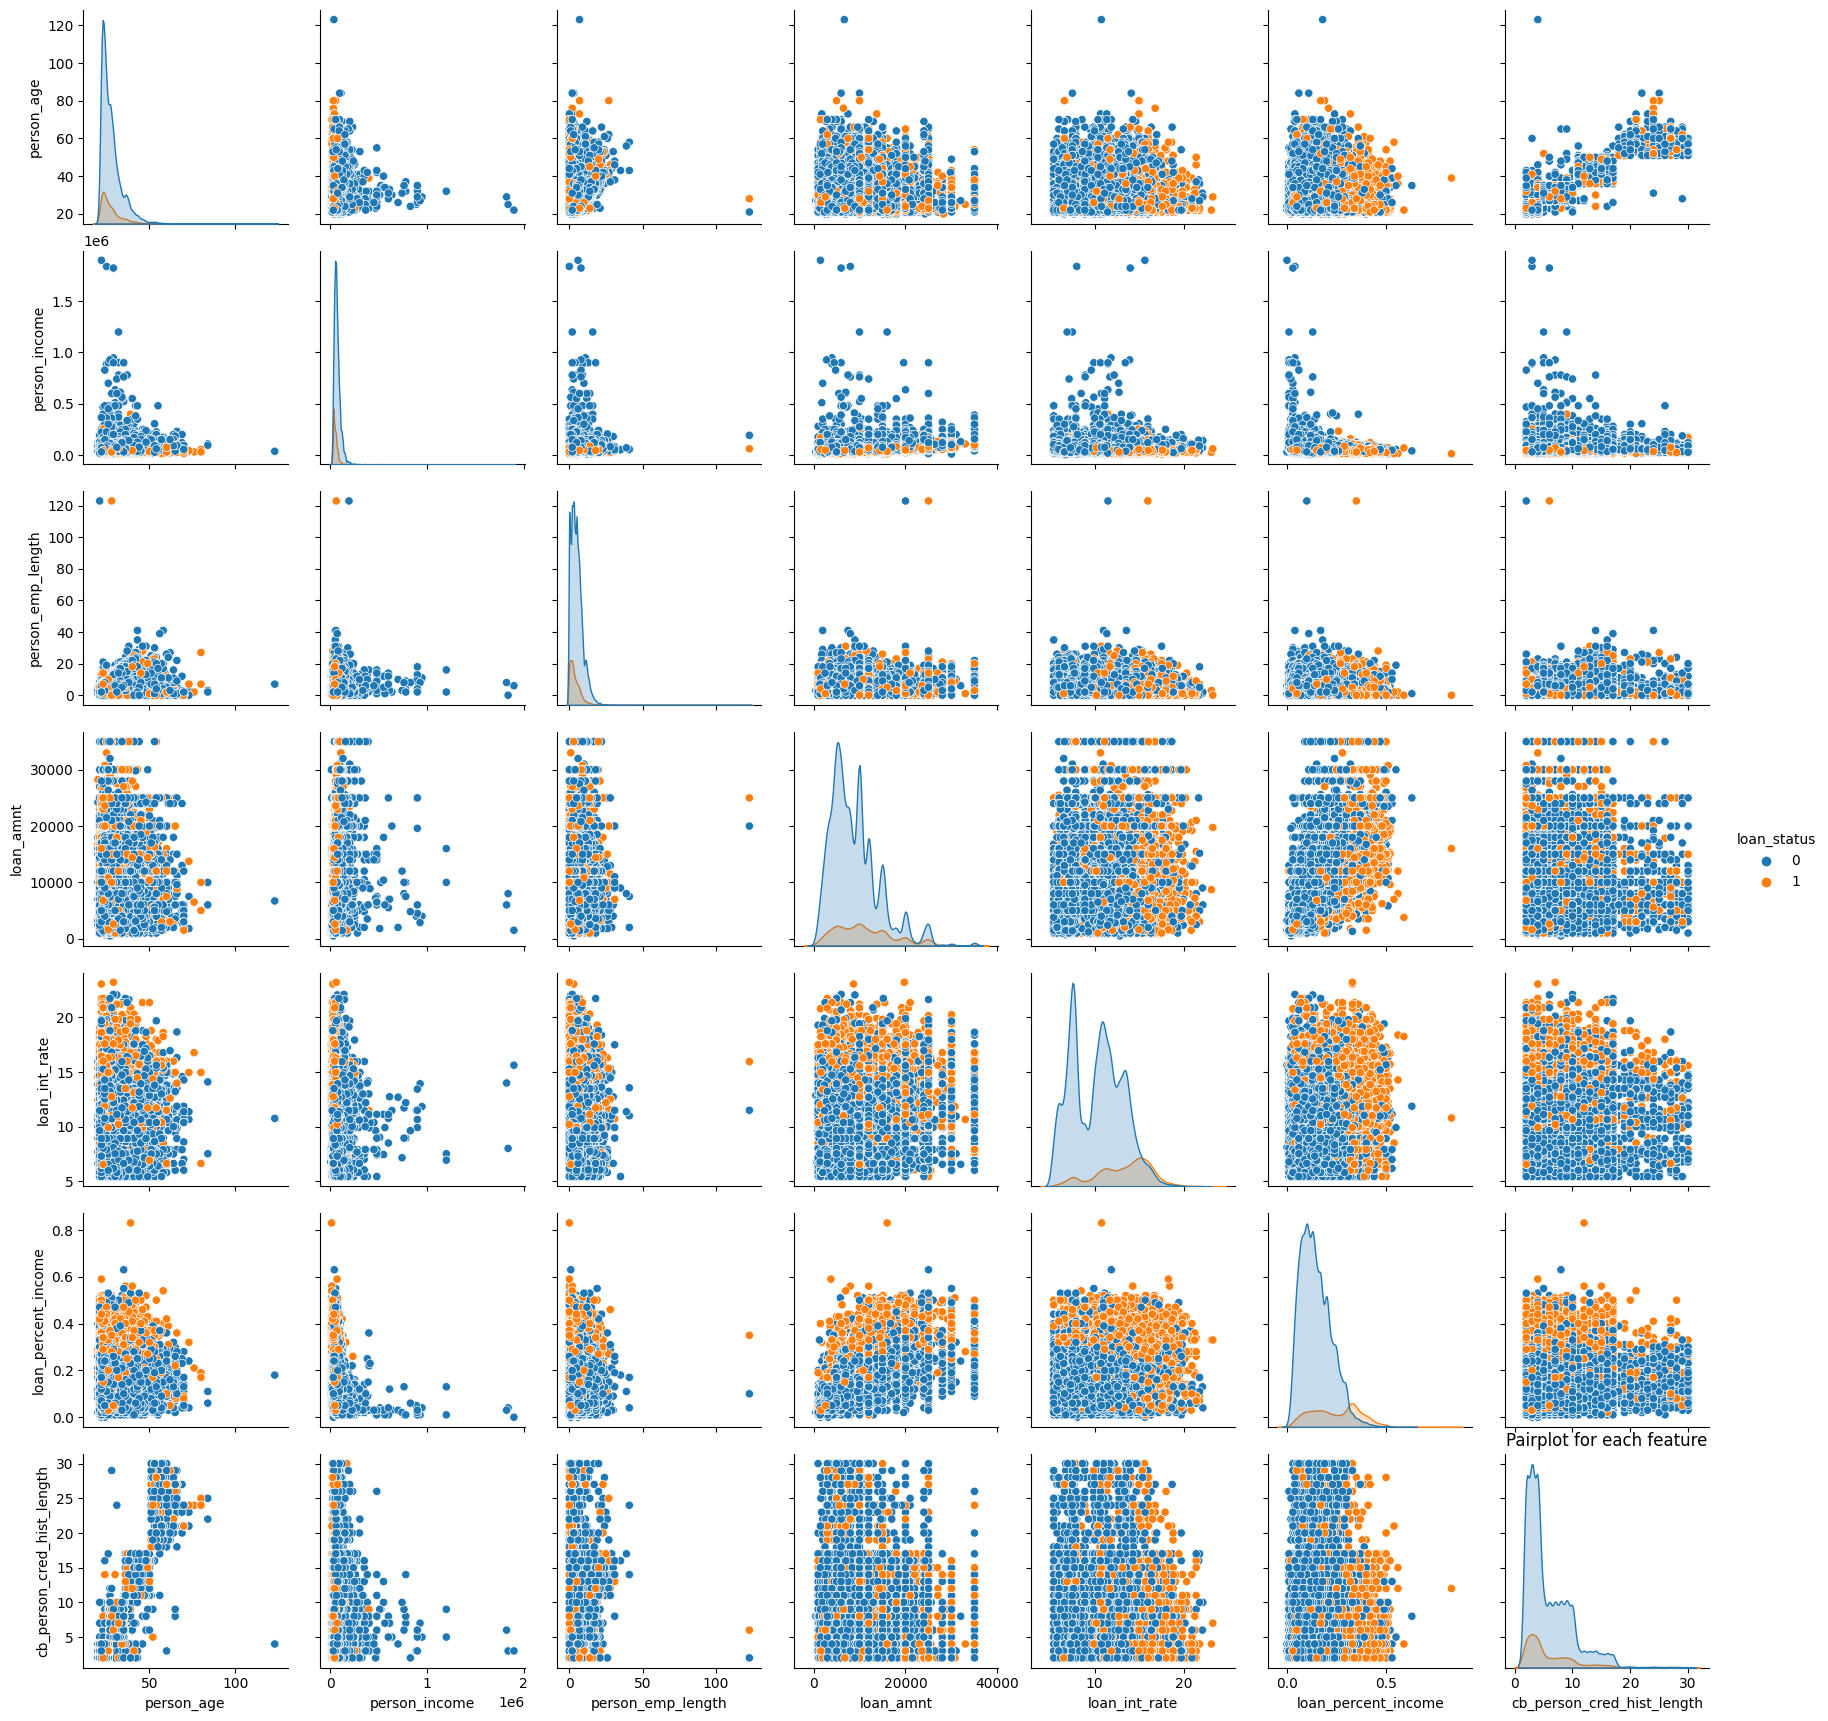

In [11]:
plt.figure(dpi=128)
sns.pairplot(df_train, hue='loan_status')
plt.title("Pairplot for each feature")
plt.show()

### Визуализация и визуальная оценка распределений числовых столбцов и их выбросов

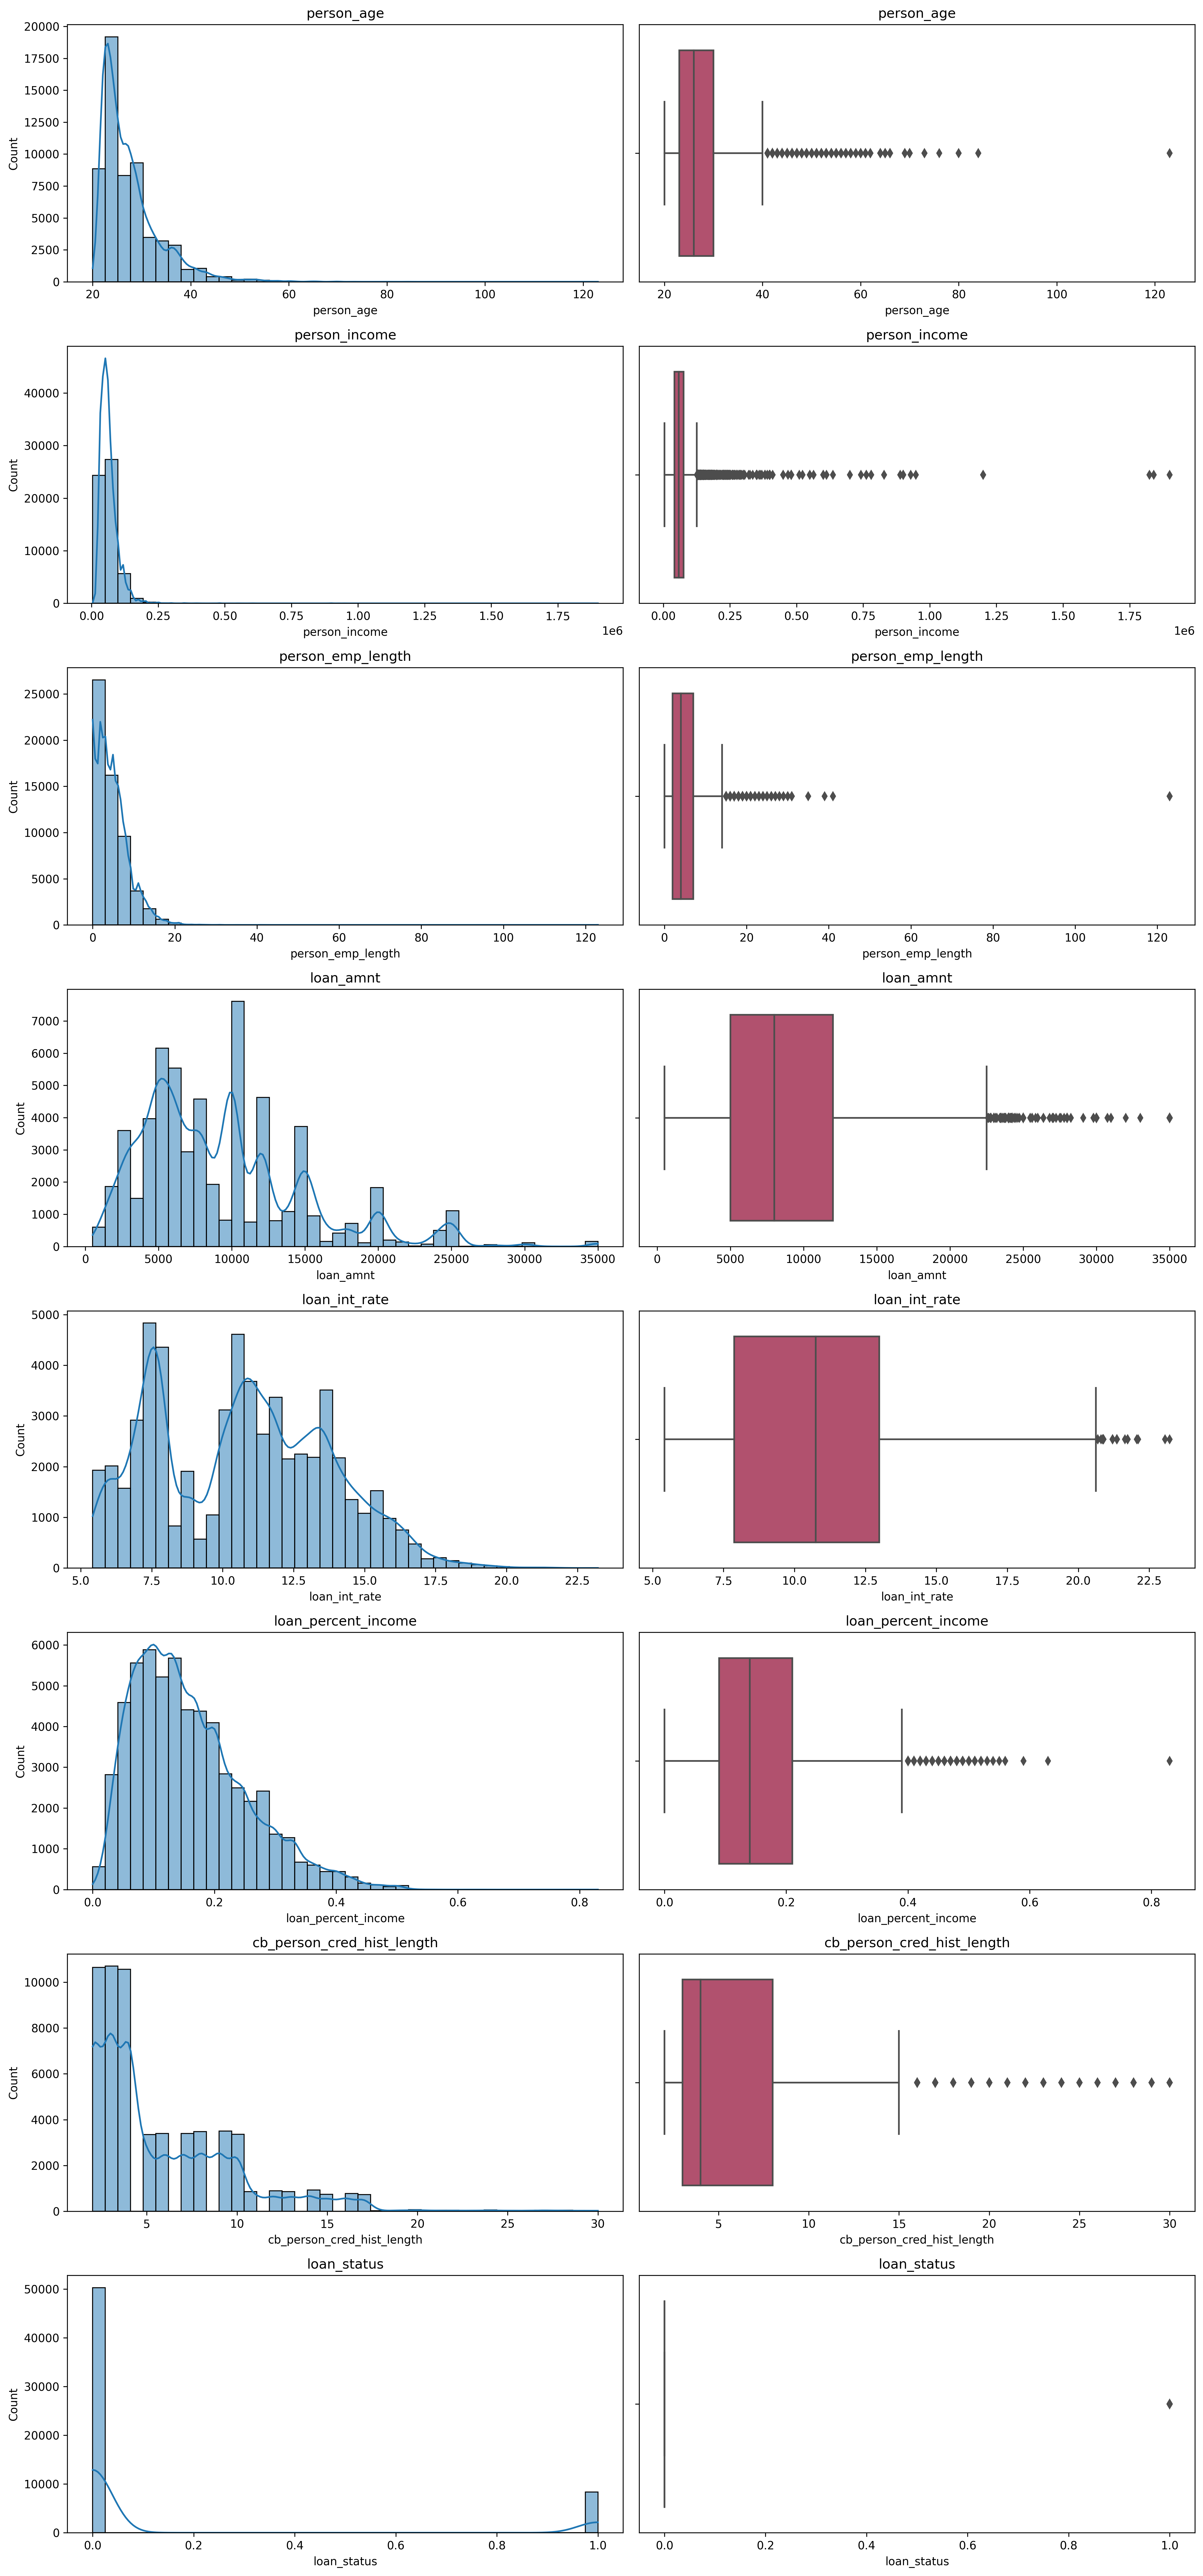

In [12]:
fig,axes = plt.subplots(len(numeric_columns),2,figsize=(15,4 * len(numeric_columns)),dpi=300)

for ind,col in enumerate(numeric_columns):
    
    plt.subplot(len(numeric_columns),2,2*ind+1)
    sns.histplot(df_train,x=col,bins=40,kde=True);
    plt.gca().set_title(col)
        
    plt.subplot(len(numeric_columns),2,2*ind+2)
    sns.boxplot(df_train,x=col,orient="h",palette="flare")
    plt.gca().set_title(col)
    
fig.tight_layout()
plt.show()

Из показанного, реально делем вывод о том, что: 
- стаж работы и возраст в 123 года - выбросные значения;
- большое количество аномалий в районе нулевых значения не наблюдается - дальше продолжаем исследование на парных диаграммах разброса scatterplot;
- выборка данных не сбалансирована относительно целевой переменной loan_status ввиду чего рассмотрим введение алгоритмов повторного отбора или smote методы заполнения и балансировки выборки;
- большая часть распределений являются кандидатами на проверку логнормальности распределения, ввиду чего будет проделан дальнейший анализ принадлежности к определенным распределениям.


Удалим выбросы, выявленные выше

In [13]:
df_train = df_train.query("person_age <= 100 & "+
                          "person_emp_length <= 100 & "+
                          "loan_percent_income <= 0.8 &"+
                          "person_income <= 1500000")

Снова визуализируем данные, чтобы убедиться в том, что выборка нормализовалась

<Figure size 819.2x614.4 with 0 Axes>

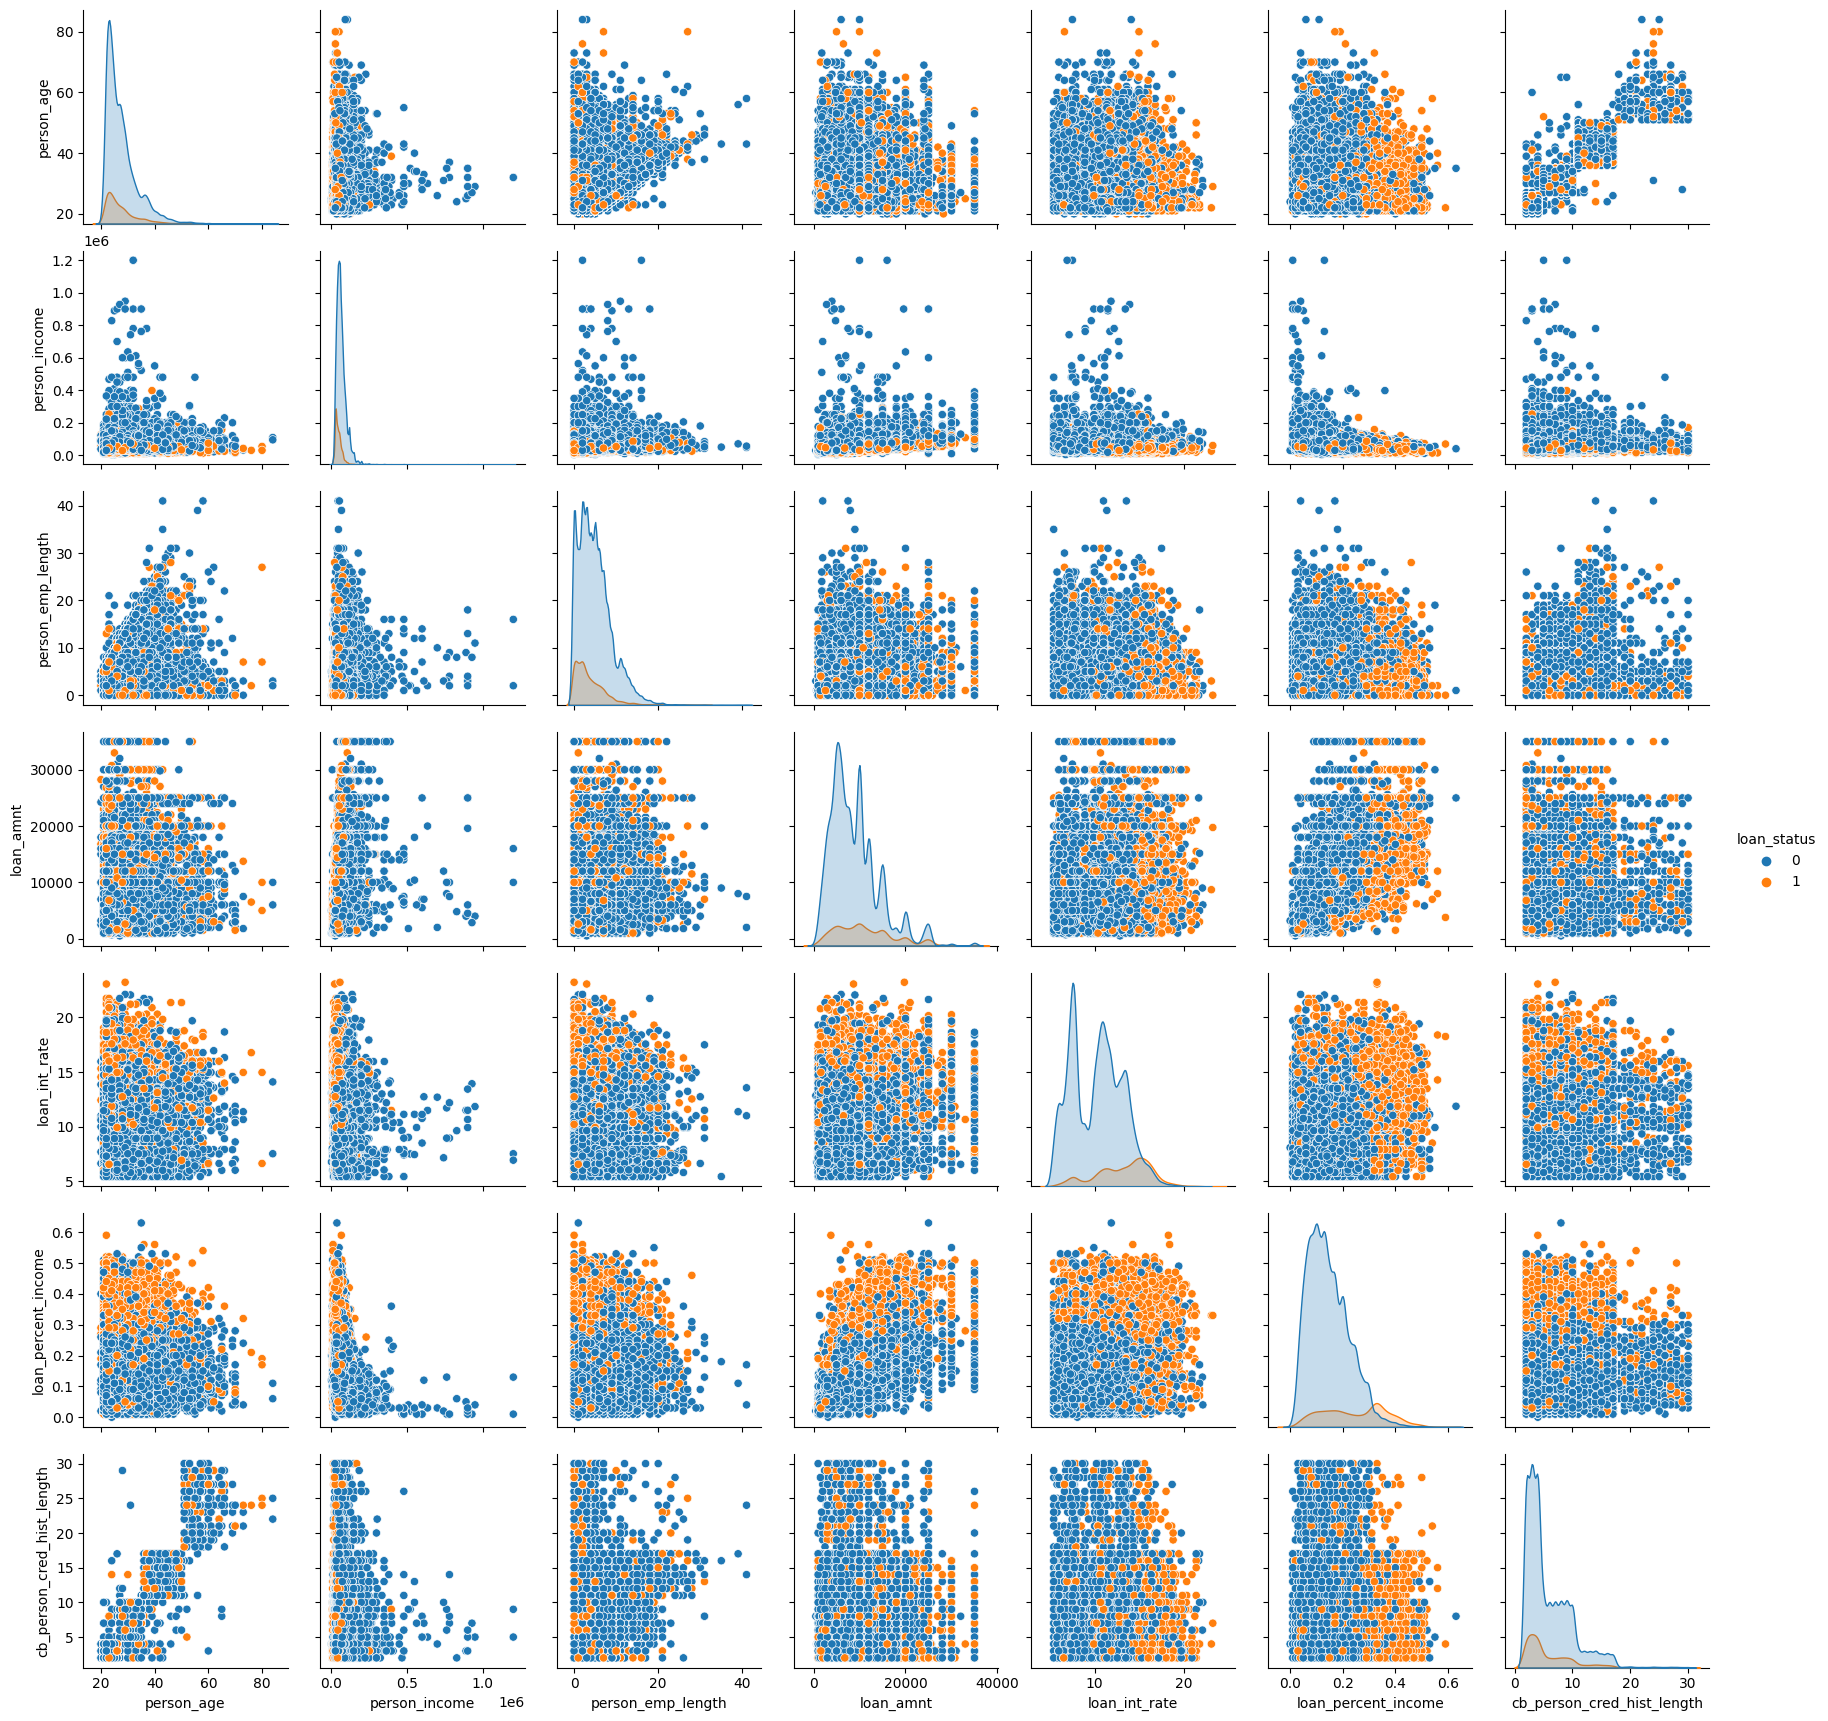

In [14]:
plt.figure(dpi=128)
sns.pairplot(df_train, hue='loan_status')
plt.show()

## **Statistical tests and analysis** (Статистические тесты и анализ) 

Применим для числовых столбцов преобразование Бокса-Кокса для нормализации распределений и стабилизации гистограмм.

In [15]:
df_train_log = df_train[numeric_columns]
numeric_columns.remove('loan_status')
df_train_log.loc[:,numeric_columns] = df_train_log.loc[:,numeric_columns].apply(lambda x: np.log(x + 1))


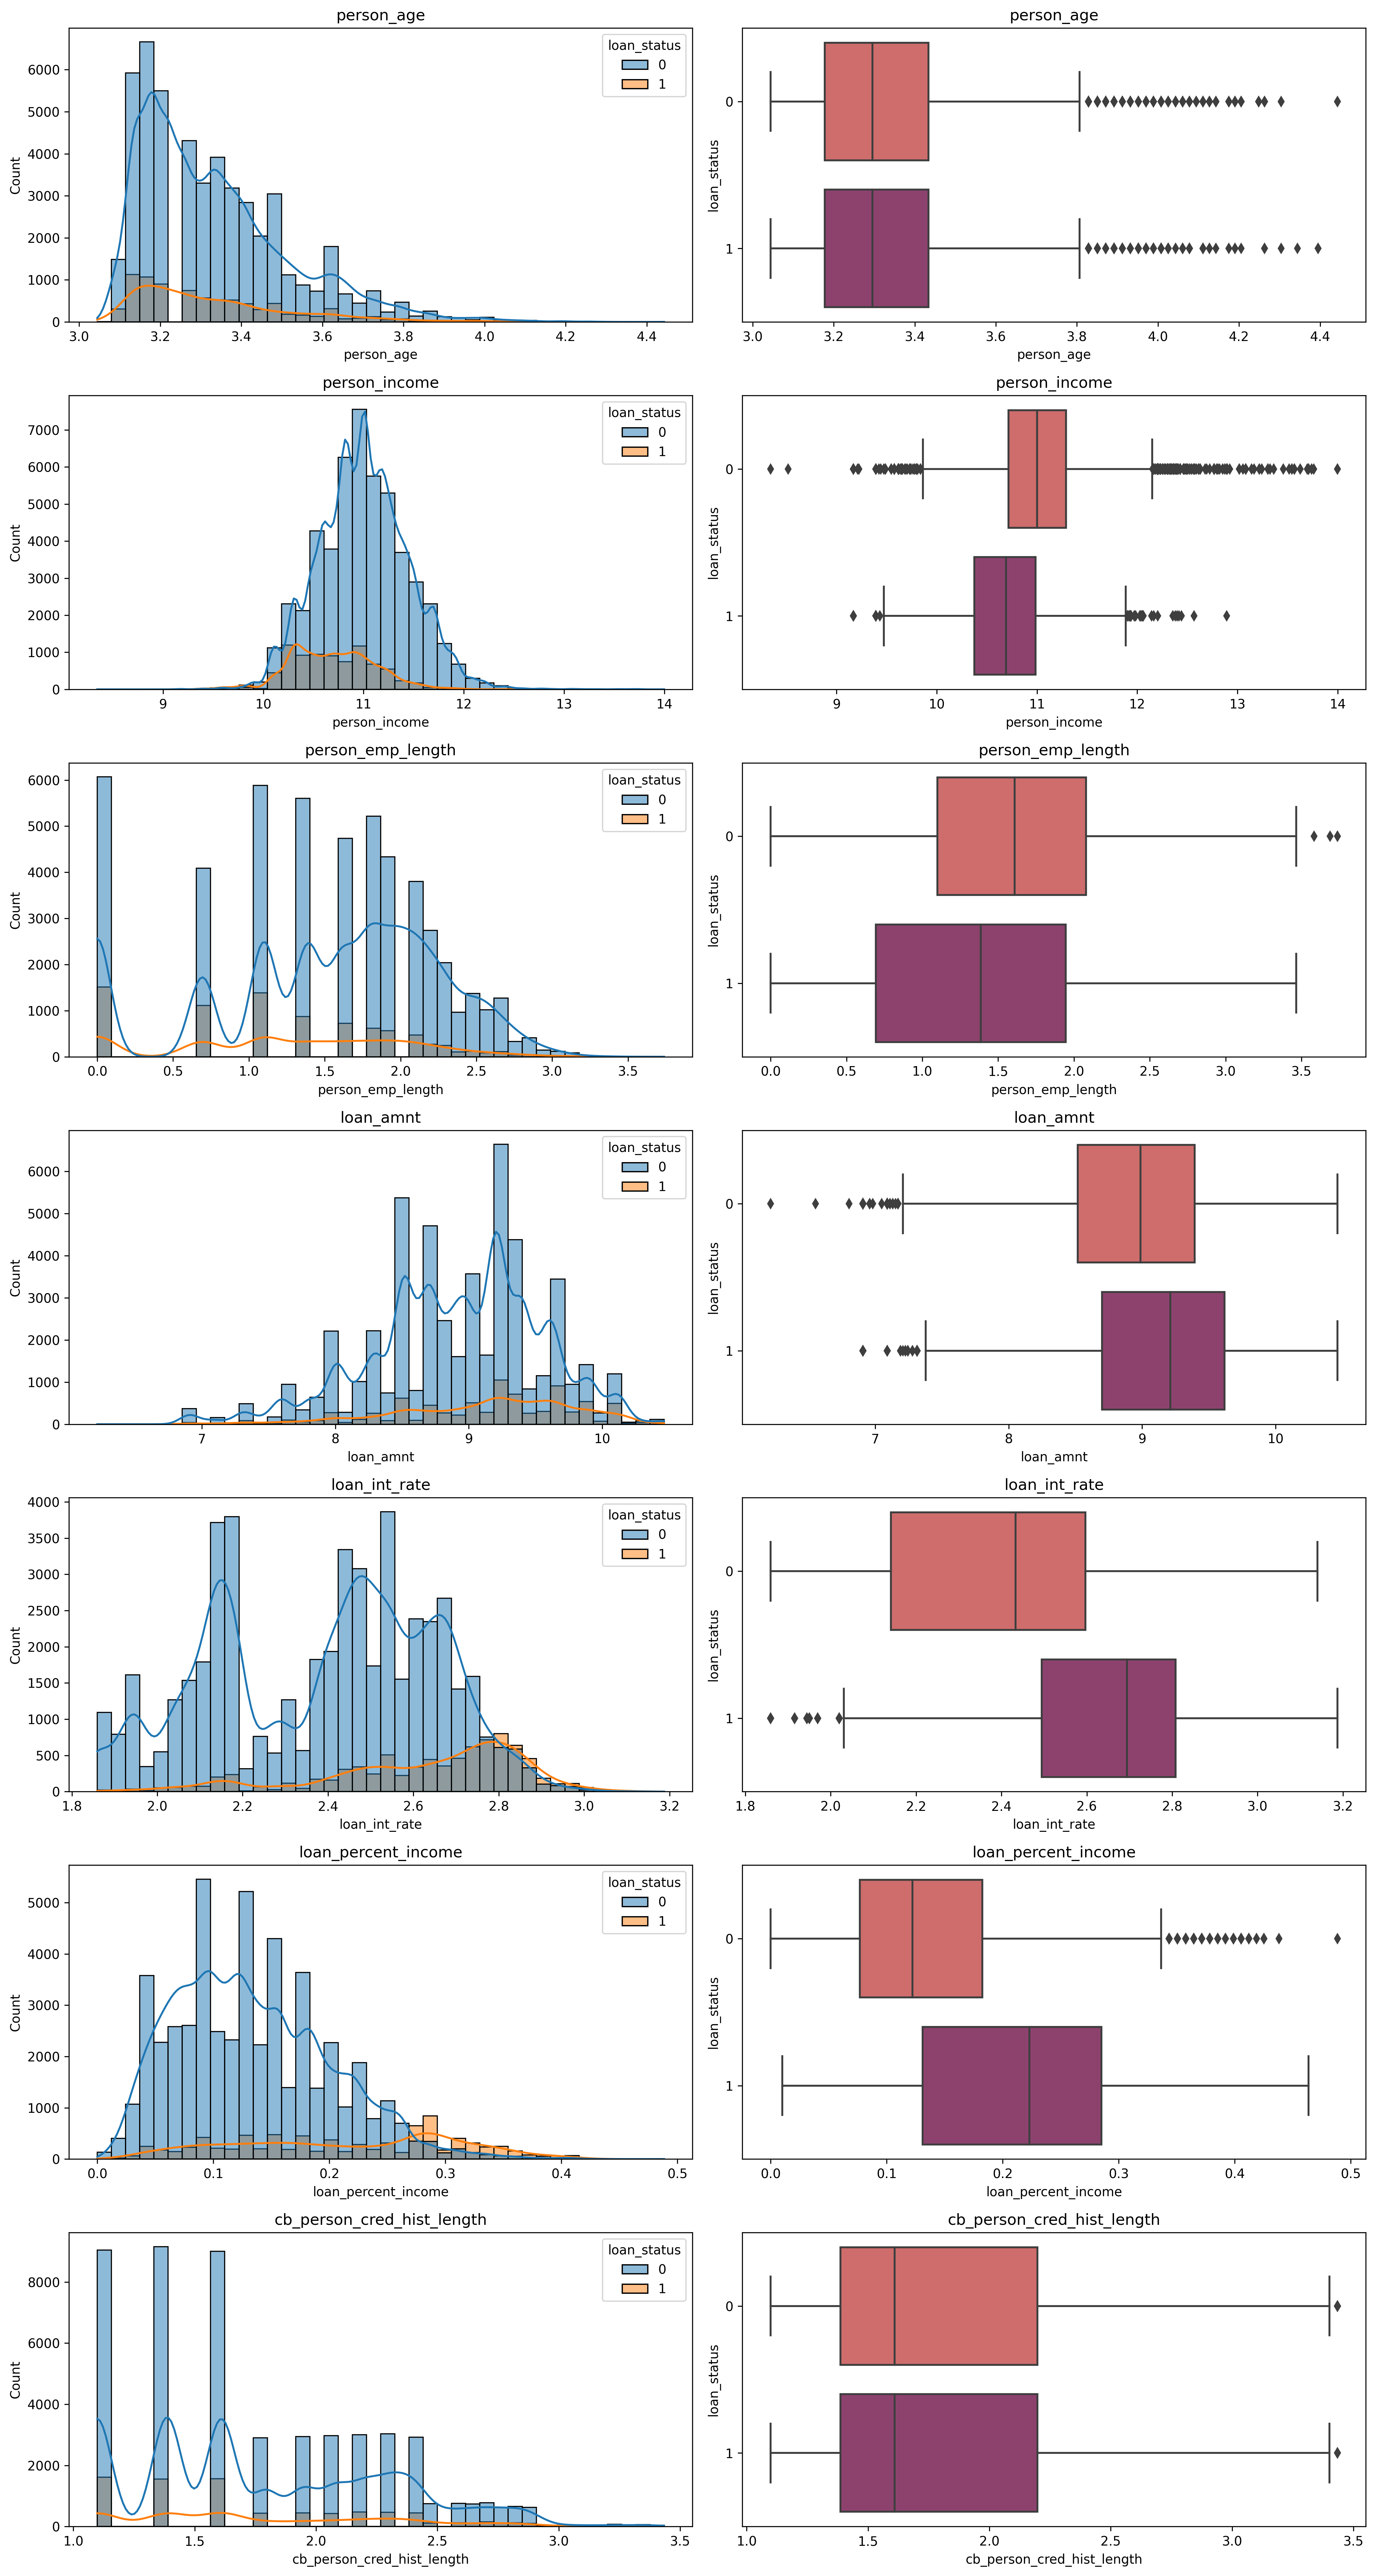

In [16]:
fig,axes = plt.subplots(len(numeric_columns),2,figsize=(15,4 * len(numeric_columns)),dpi=300)
for ind,col in enumerate(numeric_columns):
    
    plt.subplot(len(numeric_columns),2,2*ind+1)
    sns.histplot(df_train_log, x=col, bins=40, kde=True, hue='loan_status')
    plt.gca().set_title(col)
        
    plt.subplot(len(numeric_columns),2,2*ind+2)
    sns.boxplot(df_train_log, x=col, orient="h", palette="flare", y="loan_status")
    plt.gca().set_title(col)
    
fig.tight_layout()
plt.show()

В результате не видим крайне больших статистических различий в распределении числовых показателей для заемщиков с разными значениями **loan_status**, за исключением нескольких моментов:
1. На графике boxplot для показателей **person_income**, **person_emp_length**, **loan_amnt** наблюдаем визуально незначительные различия в робастных показателях центрального положения и мер разброса выборки. Перекрытие во всех случаях составляет более 80%


2. На графике boxplot для показателей **loan_percent_income**, **loan_int_rate** видим значительные расхождения в показателях между группами. В данном случае имеет смысл проверить статистическую значимость этих различий.

Приведем ряд статистических тестов на анализ различий средних значений в исследуемых группах по классификации. 

Сформулируем нулевую гипотезу **H_0**: различия в средних значениях показателей в пределах двух групп находятся в пределах статистической случайности

Сформулируем альтернативную гипотезу **H_1**: различия в средних значениях показателей в пределах двух групп значимы

Для проверки гипотез попарных сравнений используем параметрические парные сравнительные тесты, как робастные типа теста **Краскела — Уоллиса**, так и чувствительные типа теста **Манна-Уитни** и **T-теста**

In [17]:
# уровень доверия альтернативной гипотезы
p_level = 0.001

df_loan_1 = df_train.query("loan_status == 1")
df_loan_0 = df_train.query("loan_status == 0")
h_stat, p_stat = [], []
h_mw_stat, p_mw_stat = [], []
h_t_stat, p_t_stat = [], []
for idx, col in enumerate(numeric_columns):
    h, p = stats.kruskal(np.random.choice(df_loan_0[col], len(df_loan_1[col])),
                               np.random.choice(df_loan_1[col], len(df_loan_1[col])))
    h_mw, p_mw = stats.mannwhitneyu(np.random.choice(df_loan_0[col], len(df_loan_1[col])),
                               np.random.choice(df_loan_1[col], len(df_loan_1[col])))
    h_t, p_t = stats.ttest_rel(np.random.choice(df_loan_0[col], len(df_loan_1[col])),
                               np.random.choice(df_loan_1[col], len(df_loan_1[col])))
    h_stat.append(h)
    p_stat.append(p)
    h_mw_stat.append(h_mw)
    p_mw_stat.append(p_mw)
    h_t_stat.append(h_t)
    p_t_stat.append(p_t)
    

kruskal_stats_result = pd.DataFrame({"h_stat": h_stat, 
                                     "p_value": p_stat, 
                                     "column_name": numeric_columns, 
                                     "reject_H0": [p < p_level for p in p_stat]})
mannwhit_stats_result = pd.DataFrame({"h_stat": h_mw_stat, 
                                      "p_value": p_mw_stat, 
                                      "column_name": numeric_columns,
                                      "reject_H0": [p < p_level for p in p_mw_stat]}) 
t_stats_result = pd.DataFrame({"t_stat": h_t_stat, 
                               "p_value": p_t_stat, 
                               "column_name": numeric_columns,
                               "reject_H0": [p < p_level for p in p_t_stat]}) 


The Kruskal Wallis test is a statistical test used to compare two or more groups for a continuous or discrete variable. It is a non-parametric test, meaning that it assumes no particular distribution of your data and is analogous to the one-way analysis of variance (ANOVA). The Kruskal Wallis test is sometimes referred to as the one-way ANOVA on ranks or the Kruskal Wallis one-way ANOVA.

**Тест Крускала-Уоллиса** - это статистический тест, используемый для сравнения двух или более групп по непрерывной или дискретной переменной. Это непараметрический тест, то есть он не предполагает определенного распределения ваших данных и является аналогом одностороннего дисперсионного анализа (ANOVA). Тест Крускала-Уоллиса иногда называют односторонним ANOVA по рангам или односторонним ANOVA Крускала-Уоллиса.

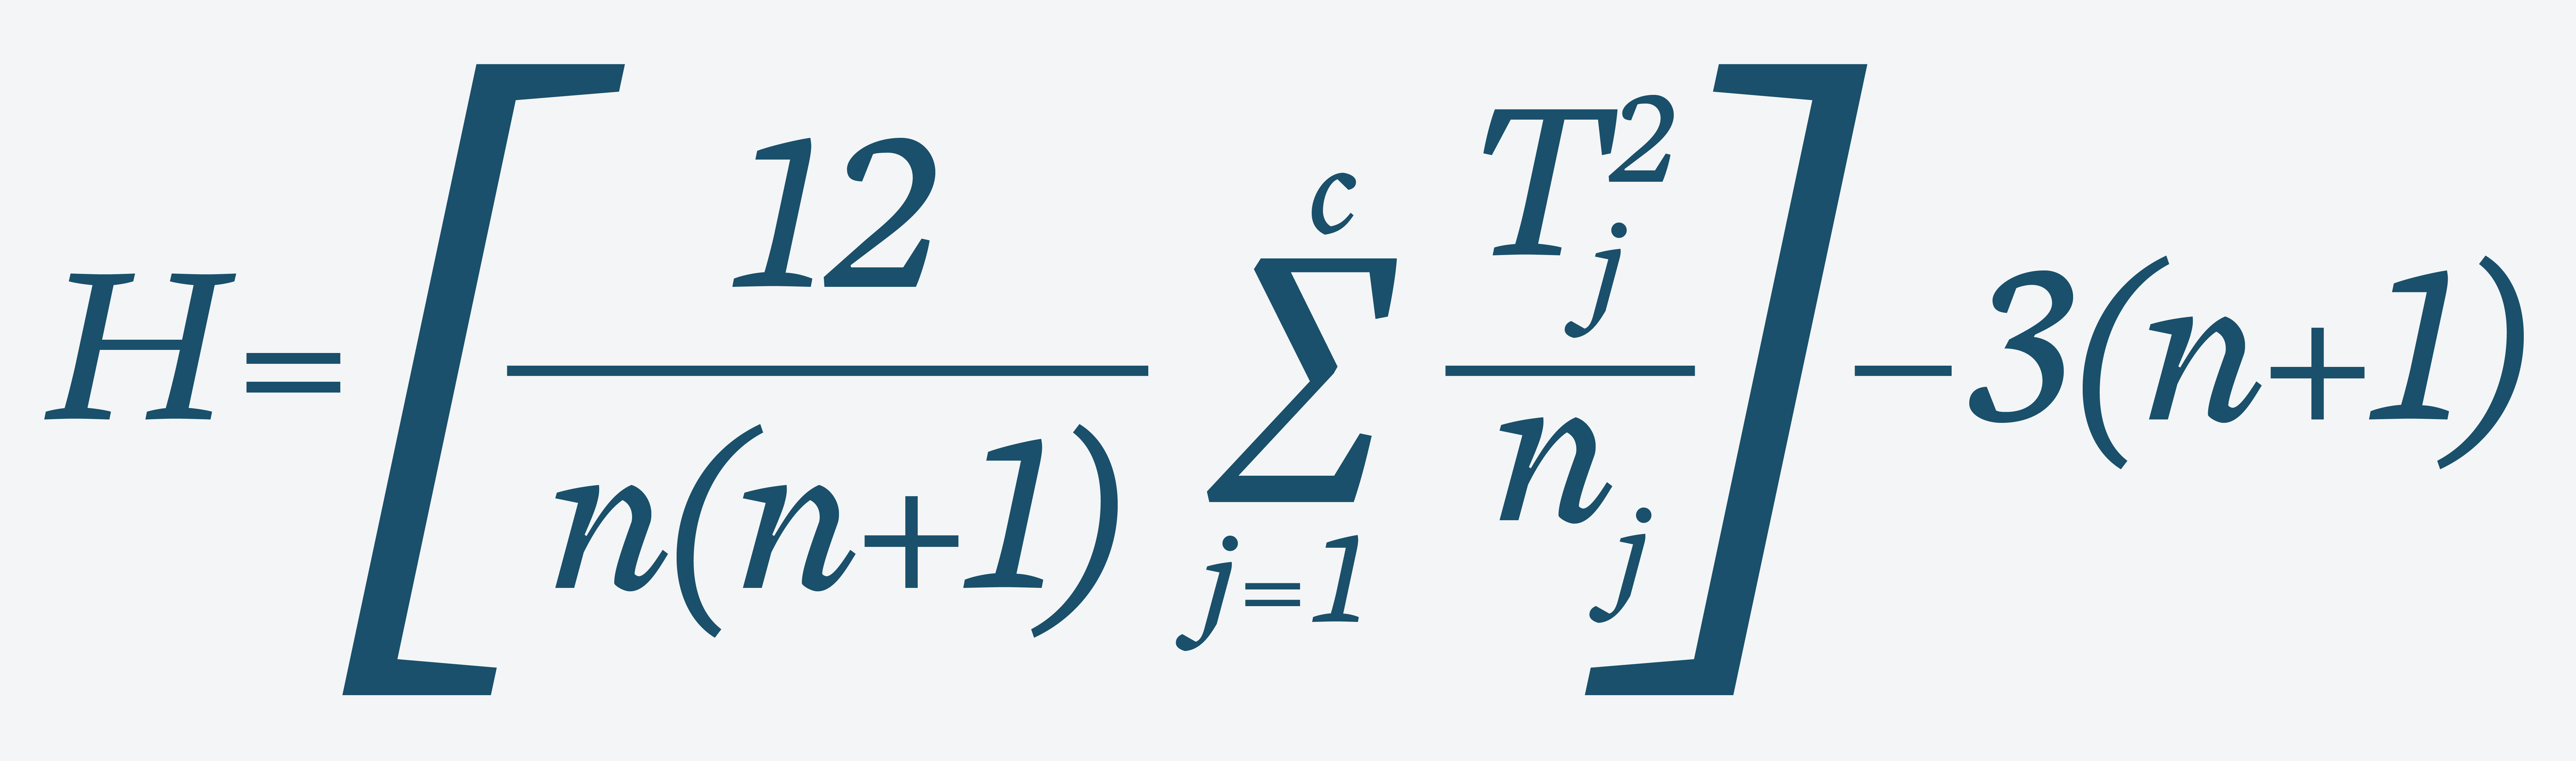

где 
- $n$ - общее количество наблюдений;
- $c$ -  количество сравниваемых групп значений по категориям (например число меток класса);
- $n_j$ - наблюдений с одинаковой категорией;
- $T_j$ - сумма порядков в общем упоряддоченном наборе наблюдений
- Количество степений свободы $df = c - 1$
- $H \div \chi^2_{1-\alpha,\ df}$

Нулевая гипотеза **H0**: выборки распределены одинаково

Нулевая гипотеза **H1**: между первой и остальными выборками существует смещение

In [18]:
kruskal_stats_result.sort_values(by="p_value", ascending=False)

h_stat        p_value                 column_name  reject_H0
0     2.969635   8.484099e-02                  person_age      False
6     3.490685   6.171504e-02  cb_person_cred_hist_length      False
2   460.119274  4.528300e-102           person_emp_length       True
3   526.609822  1.543494e-116                   loan_amnt       True
1  1791.989757   0.000000e+00               person_income       True
4  3432.734030   0.000000e+00               loan_int_rate       True
5  2896.983870   0.000000e+00         loan_percent_income       True

In [19]:
mannwhit_stats_result.sort_values(by="p_value", ascending=False)

h_stat        p_value                 column_name  reject_H0
0  35486352.5   3.859128e-02                  person_age      False
6  35689545.0   6.123637e-03  cb_person_cred_hist_length      False
2  41763800.5  1.418691e-110           person_emp_length       True
3  27143352.5  1.729470e-135                   loan_amnt       True
1  48657227.0   0.000000e+00               person_income       True
4  16176479.0   0.000000e+00               loan_int_rate       True
5  17966835.5   0.000000e+00         loan_percent_income       True

In [20]:
t_stats_result.sort_values(by="p_value", ascending=False)

t_stat        p_value                 column_name  reject_H0
0   0.348261   7.276532e-01                  person_age      False
6   2.420922   1.550238e-02  cb_person_cred_hist_length      False
2  18.763508   5.673627e-77           person_emp_length       True
3 -25.222014  2.444143e-135                   loan_amnt       True
1  39.847535   0.000000e+00               person_income       True
4 -66.833461   0.000000e+00               loan_int_rate       True
5 -64.863931   0.000000e+00         loan_percent_income       True

Важными признаками для классификации отбираем те, которые реально имеют статистически значимые различия в группах с разными метками целевого класса. Дальнейший woe анализ будет повторно верифицировать наши результаты

### Визуальная оценка влияния категориальных признаков на значение класса

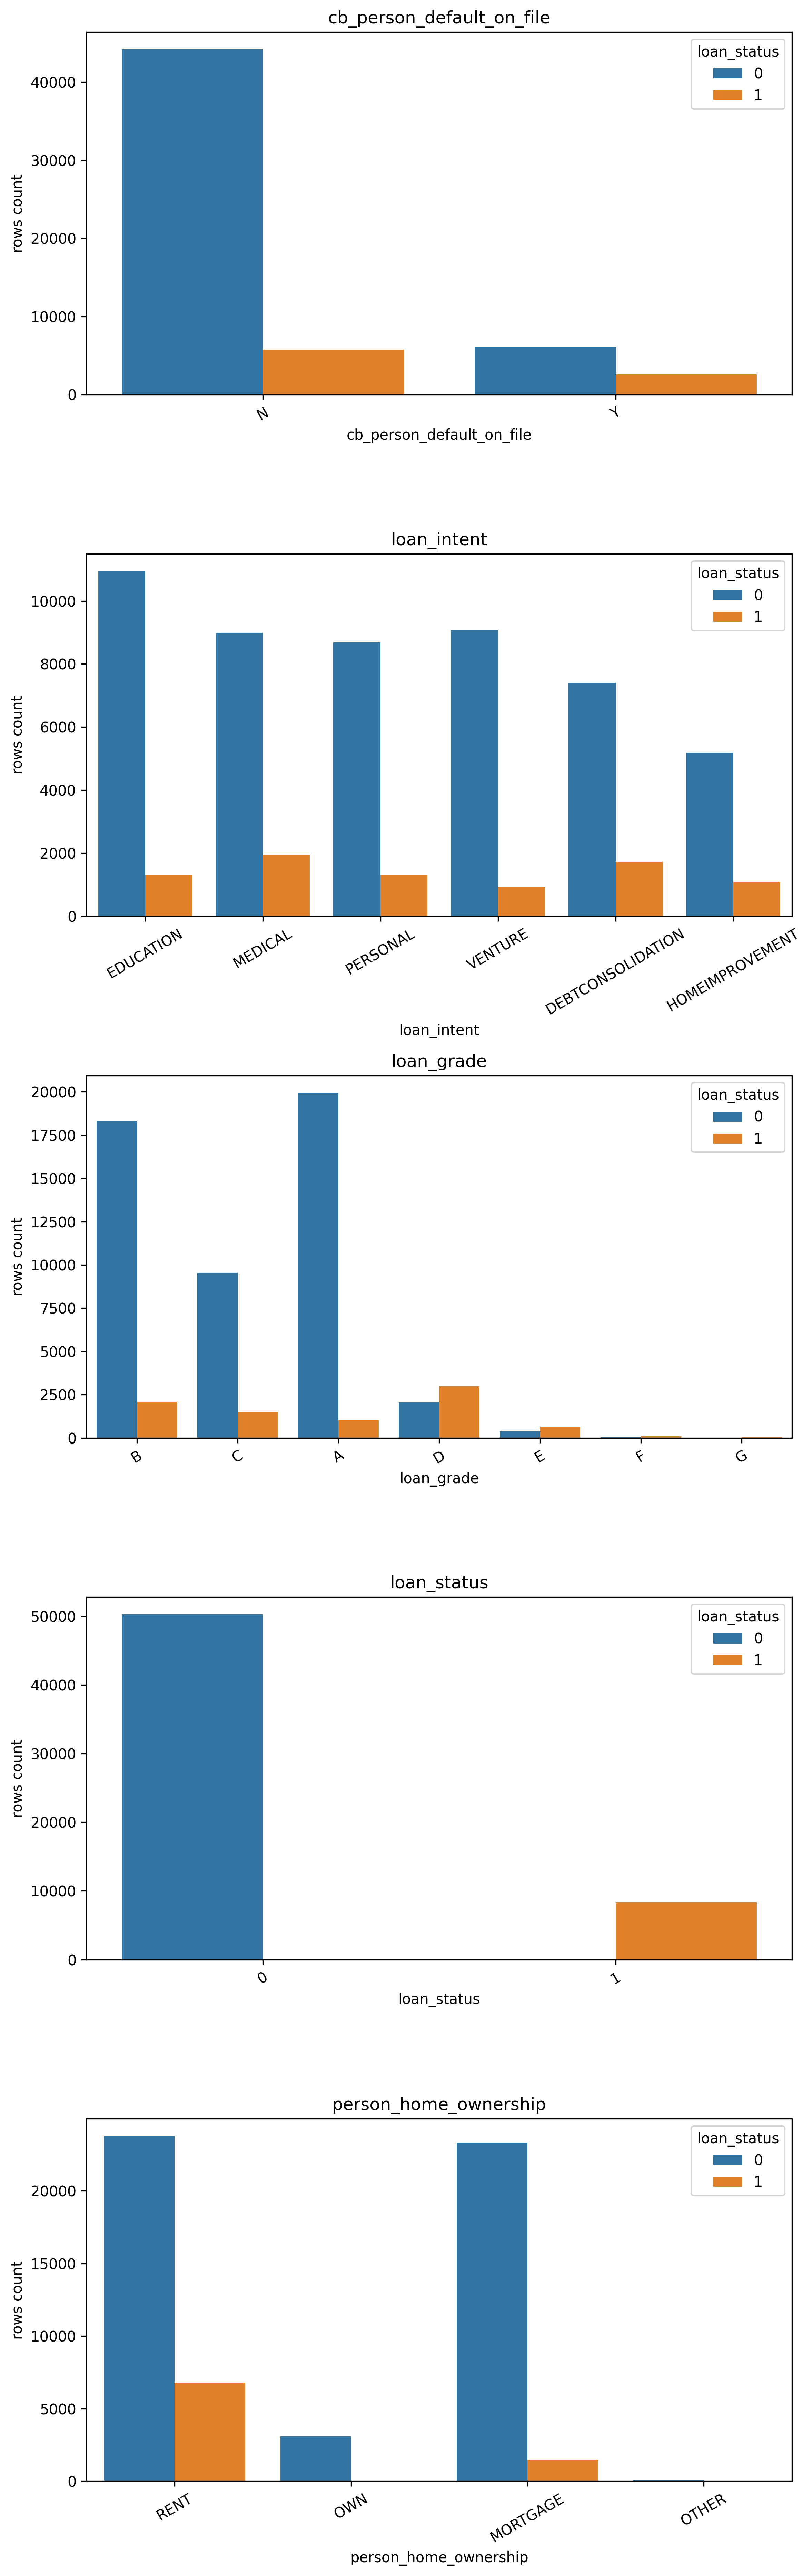

In [21]:
factor_columns = list(set(df_train.columns).difference(set(numeric_columns)))

fig,axes = plt.subplots(len(factor_columns),1,figsize=(8, 5 * len(factor_columns)), dpi=300)
for ind,col in enumerate(factor_columns):
    
    plt.subplot(len(factor_columns),1,ind+1)
    sns.barplot(df_train,x=col,y="loan_status", hue="loan_status", estimator='size')
    plt.xticks(rotation=30)
    plt.ylabel("rows count")
    plt.gca().set_title(col)
    
fig.tight_layout()
plt.show()

# **Feature Preparition** (Подготовка признаков)

### Эвристические признаки

**Отношение стажа работы к возрасту**

Новый признак: ```emp_length_ratio = person_emp_length / person_age```

Описание: Показывает, какую часть своей жизни человек был трудоустроен.

Преимущества:

• Отражает стабильность занятости относительно возраста.

• Может помочь выявить заемщиков с нестабильной трудовой историей.


In [22]:
df_train['emp_length_ratio'] = df_train.person_emp_length / df_train.person_age
numeric_columns.append('emp_length_ratio')

**Взаимодействие между кредитным рейтингом и процентной ставкой**

Новый признак: ```adjusted_int_rate = loan_int_rate / loan_grade_numeric```

Описание: Корректировка процентной ставки с учетом кредитного рейтинга.

Преимущества:

• Выявляет заемщиков с аномально высокими ставками для их кредитного рейтинга.

• Может указывать на дополнительные риски, не отраженные в рейтинге.

In [23]:
df_train['loan_grade_numeric'] = df_train.loan_grade.replace(dict(zip(('A', 'B', 'C', 'D', 'E', 'F', 'G'), range(7, 0, -1))))
df_train['adjusted_int_rate'] = df_train.loan_int_rate / df_train.loan_grade_numeric
numeric_columns.append('adjusted_int_rate')

**Взаимодействие между наличием прежних дефолтов и длиной кредитной истории**

Новый признак: ```default_history_interaction = (cb_person_default_on_file == 'Y') * cb_person_cred_hist_length```

Преимущества:

• Выявляет заемщиков с дефолтами в прошлом и длительной кредитной историей.

• Помогает оценить, насколько давно был совершён дефолт.

In [24]:
df_train['default_history_interaction'] = (df_train.cb_person_default_on_file == 'Y') * df_train.cb_person_cred_hist_length
numeric_columns.append('default_history_interaction')

**Отношение длины кредитной истории к возрасту**

Новый признак: ```cred_hist_to_age_ratio = cb_person_cred_hist_length / person_age```

Преимущества:

• Показывает, какую часть жизни заемщик использует кредитные продукты.

• Может указывать на опытность в использовании кредитов.

In [25]:
df_train['cred_hist_to_age_ratio'] = df_train.cb_person_cred_hist_length / df_train.person_age
numeric_columns.append('cred_hist_to_age_ratio')

**Взаимодействие финансовых признаков**

Новые признаки:

• ```income_per_age = person_income / person_age```

• ```loan_amnt_to_cred_hist = loan_amnt / cb_person_cred_hist_length```

Преимущества:

• Учитывает эффективность заработка относительно возраста.

• Помогает выявлять несоответствия между запрашиваемой суммой и финансовым положением.

In [26]:
df_train['income_per_age'] = df_train.person_income / df_train.person_age
numeric_columns.append('income_per_age')

In [27]:
df_train['loan_amnt_to_cred_hist'] = df_train.loan_amnt / df_train.cb_person_cred_hist_length
numeric_columns.append('loan_amnt_to_cred_hist')

***Признак "Скоринг риска"***

Новый признак: risk_score

Описание:

• Создать интегральный показатель риска на основе нескольких признаков:

  • ```risk_score = loan_grade_numeric * loan_int_rate * (1 + default_on_file)```
  
Преимущества:

• Комплексно учитывает несколько факторов риска.

• Может улучшить предсказания моделей за счет обобщения рисковых характеристик.

In [28]:
df_train['cb_person_default_on_file_numeric'] = df_train.cb_person_default_on_file.replace(dict(zip(('N', 'Y'),(0, 1))))
df_train['risk_score'] = df_train.loan_grade_numeric * df_train.loan_int_rate * (1 + df_train.cb_person_default_on_file_numeric)
numeric_columns.append('risk_score')

In [29]:
df_train.drop(['loan_grade_numeric', 'cb_person_default_on_file_numeric'], axis=1, inplace=True)

Создание полиномиальных признаков

Новые признаки:

• Квадраты и кубы непрерывных переменных, например, ```loan_amnt²```, ```loan_int_rate²```.

Преимущества:

• Позволяет моделям улавливать нелинейные зависимости.

• Может улучшить качество предсказаний при использовании алгоритмов, способных работать с полиномиальными признаками.

In [30]:
for i in range(len(numeric_columns)):
    df_train[numeric_columns[i]+'_squared'] = df_train[numeric_columns[i]]*df_train[numeric_columns[i]]
    numeric_columns.append(numeric_columns[i]+'_squared')

In [31]:
numeric_columns

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'emp_length_ratio',
 'adjusted_int_rate',
 'default_history_interaction',
 'cred_hist_to_age_ratio',
 'income_per_age',
 'loan_amnt_to_cred_hist',
 'risk_score',
 'person_age_squared',
 'person_income_squared',
 'person_emp_length_squared',
 'loan_amnt_squared',
 'loan_int_rate_squared',
 'loan_percent_income_squared',
 'cb_person_cred_hist_length_squared',
 'emp_length_ratio_squared',
 'adjusted_int_rate_squared',
 'default_history_interaction_squared',
 'cred_hist_to_age_ratio_squared',
 'income_per_age_squared',
 'loan_amnt_to_cred_hist_squared',
 'risk_score_squared']

### ***WoE анализ***

**Information Value (IV)** IV refers to a measure that quantifies the predictive power of an individual feature (independent variable) in relation to the target variable. It is calculated by taking the sum of the products of the differences in the proportion of goods and bads (or events and non-events) and the Weight of Evidence (WoE) for each category or bin of a feature.

IV can be used to rank features in terms of their importance or strength of association with the outcome variable. The value of IV helps in determining how well a feature is able to distinguish between the target variable's classes (for example, default vs. non-default in credit scoring).

The IV of a feature is a single scalar value. The interpretation of IV values is often guided by rules of thumb, indicating the predictive strength of the feature:

- IV < 0.02: Not useful for prediction
- 0.02 =< IV < 0.1: Weak predictive power
- 0.1 =< IV < 0.3: Medium predictive power
- 0.3 =< IV: Strong predictive power

**Информационная ценность (IV)** IV - это показатель, который количественно оценивает предсказательную силу отдельного признака (независимой переменной) по отношению к целевой переменной. Он рассчитывается как сумма произведений разницы в доле хороших и плохих признаков (или событий и несобытий) и веса доказательств (WoE) для каждой категории или бина признака.

IV можно использовать для ранжирования признаков по степени их важности или силе связи с итоговой переменной. Значение IV помогает определить, насколько хорошо признак способен различать классы целевой переменной (например, дефолт и не дефолт в кредитном скоринге).

IV признака - это единичное скалярное значение. При интерпретации значений IV часто руководствуются эмпирическими правилами, указывающими на предсказательную силу признака:

- IV < 0,02: не пригоден для прогнозирования
- 0,02 =< IV < 0,1: слабая предсказательная сила
- 0,1 =< IV < 0,3: Средняя предсказательная сила
- 0,3 =< IV: Сильная предсказательная сила

In [32]:
!pip install woe_iv_bin==0.1.2 -q -q -q

In [33]:
from woe_iv_bin import categorical_woe
from woe_iv_bin import continuous_woe

Формула для расчета WoE для категории с меткой $k$:
$$
WoE_{k} = log_{e}{\left( \cfrac{N^{target-}_{k}}{N^{target+}_{k}} \right)}
$$
где 
- $N^{target-}_{k}$ $-$ количество записей в группе категориального предиктора с меткой $k$ и целевым значением $0$, то есть количество "не событий" в группе фактора
- $N^{target+}_{k}$ $-$ количество записей в группе категориального предиктора с меткой $k$ и целевым значением $1$, то есть количество "событий" в группе фактора


Формула расчета IV для категории с меткой K:
$$
IV_{k} = \left(N^{target+}_{k} - N^{target-}_{k}\right) \cdot WoE_{k}
$$

Формула расчета общего IV:
$$
IV = \sum_{k\ \in\ list(k)} IV_{k}
$$

In [34]:
woe_results = categorical_woe(df_train, 
                              cat_variable_name="person_home_ownership", 
                              y_df=df_train['loan_status'])
print(woe_results)

               WoE        IV  total_IV
feature                               
MORTGAGE -0.960516  0.275208  0.600796
OTHER     0.188179  0.000061  0.600796
OWN      -2.462954  0.138891  0.600796
RENT      0.544781  0.186635  0.600796


In [35]:
df_binned, optimized_bins, binning_woe_results = continuous_woe(df_train,
                                                                feature = 'person_income', 
                                                                target = 'loan_status', 
                                                                max_bins=20, 
                                                                min_samples_bin=0.05)

binning_woe_results

optimized_bin  optimized_WoE  optimized_IV  \
0              (4200.0, 31200.0]       1.122681      0.184334   
1             (31200.0, 39480.0]       0.785021      0.078142   
2             (39480.0, 45000.0]       0.100052      0.001134   
3             (45000.0, 50000.0]      -0.250218      0.005657   
4             (50000.0, 58000.0]       0.189175      0.003636   
5             (58000.0, 63000.0]      -0.389198      0.013062   
6             (63000.0, 72000.0]      -0.473584      0.020544   
7   (72000.0, 83031.60000000027]      -0.444795      0.015008   
8  (83031.60000000027, 100000.0]      -1.146021      0.087435   
9          (100000.0, 1200000.0]      -1.432095      0.121301   

   total_optimized_IV  
0            0.530252  
1            0.530252  
2            0.530252  
3            0.530252  
4            0.530252  
5            0.530252  
6            0.530252  
7            0.530252  
8            0.530252  
9            0.530252

In [36]:
import ast
def interval_type(s):
    """Parse interval string to Interval"""
    table = str.maketrans({'[': '(', ']': ')'})
    left_closed = s.startswith('[')
    right_closed = s.endswith(']')
    left, right = ast.literal_eval(s.translate(table))
    t = 'neither'
    if left_closed and right_closed:
        t = 'both'
    elif left_closed:
        t = 'left'
    elif right_closed:
        t = 'right'
    return pd.Interval(left, right, closed=t)


def apply_bounds_open(series_interval):
    series_interval = list(series_interval)
    series_interval[0] = pd.Interval(left = -np.inf, right=series_interval[0].right, closed='right')
    series_interval[-1] = pd.Interval(left = series_interval[-1].left, right=np.inf)
    return series_interval


def woe_generate_col(series, binning_woe_results):
    result_bins = apply_bounds_open(binning_woe_results['optimized_bin'].apply(interval_type))
    series = pd.cut(series, result_bins)
    return series

In [37]:
target_col = 'loan_status'
max_bins = 15
min_samples_bin = 1
binning_woe_dict = {}
for col in numeric_columns:
    _, _, binning_woe_results = continuous_woe(df_train,
                                              feature = col, 
                                              target = target_col, 
                                              max_bins= max_bins, 
                                              min_samples_bin=min_samples_bin)
    binning_woe_dict[col] = binning_woe_results
    df_train.loc[:, f"woe_{col}"] = woe_generate_col(df_train.loc[:, col], binning_woe_results)

df_train.drop(["binned", "optimized_binned_feature"], axis = 1, inplace=True)

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58638 entries, 0 to 58644
Data columns (total 61 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   person_age                               58638 non-null  int64   
 1   person_income                            58638 non-null  int64   
 2   person_home_ownership                    58638 non-null  object  
 3   person_emp_length                        58638 non-null  float64 
 4   loan_intent                              58638 non-null  object  
 5   loan_grade                               58638 non-null  object  
 6   loan_amnt                                58638 non-null  int64   
 7   loan_int_rate                            58638 non-null  float64 
 8   loan_percent_income                      58638 non-null  float64 
 9   cb_person_default_on_file                58638 non-null  object  
 10  cb_person_cred_hist_length             

### **Кодирование категорий dummy переменными**

In [39]:
cat_feature_cols = list(set(df_train.columns).difference(numeric_columns))
cat_feature_cols = cat_feature_cols[0:2] + cat_feature_cols[3:]
cat_feature_cols

['woe_person_income_squared',
 'woe_cb_person_cred_hist_length_squared',
 'woe_person_income',
 'loan_intent',
 'woe_loan_int_rate',
 'woe_adjusted_int_rate',
 'woe_loan_amnt_squared',
 'woe_emp_length_ratio_squared',
 'woe_loan_percent_income_squared',
 'woe_default_history_interaction_squared',
 'woe_default_history_interaction',
 'woe_risk_score_squared',
 'woe_person_age',
 'woe_risk_score',
 'woe_person_emp_length_squared',
 'woe_cb_person_cred_hist_length',
 'loan_status',
 'woe_loan_int_rate_squared',
 'woe_cred_hist_to_age_ratio_squared',
 'woe_loan_amnt_to_cred_hist',
 'woe_loan_amnt_to_cred_hist_squared',
 'woe_adjusted_int_rate_squared',
 'loan_grade',
 'woe_cred_hist_to_age_ratio',
 'person_home_ownership',
 'woe_person_emp_length',
 'woe_income_per_age',
 'woe_loan_amnt',
 'cb_person_default_on_file',
 'woe_loan_percent_income',
 'woe_income_per_age_squared',
 'woe_emp_length_ratio']

In [40]:
df_train = df_train.join(pd.get_dummies(df_train.loc[:,cat_feature_cols], prefix=cat_feature_cols, drop_first=False, dtype=int))

ValueError: Length of 'prefix' (32) did not match the length of the columns being encoded (31).

In [ ]:
df_train = df_train.drop(cat_feature_cols, axis=1)

In [ ]:
df_train = df_train.drop(numeric_columns, axis=1)

In [ ]:
df_train.shape

In [ ]:
df_train

# **Data Preparition function** (**Функция для предобработки данных**)

In [41]:
def data_prep(df):
    df = df.drop("id", axis=1)
    target_col = 'loan_status'
    numeric_columns = list(df.describe().columns)
    for i in range(len(numeric_columns)):
        df[numeric_columns[i]+'_squared'] = df[numeric_columns[i]]*df[numeric_columns[i]]
        numeric_columns.append(numeric_columns[i]+'_squared')
    df['emp_length_ratio'] = df.person_emp_length / df.person_age
    numeric_columns.append('emp_length_ratio')
    df['loan_grade_numeric'] = df.loan_grade.replace(dict(zip(('A', 'B', 'C', 'D', 'E', 'F', 'G'), range(7, 0, -1))))
    df['adjusted_int_rate'] = df.loan_int_rate / df.loan_grade_numeric
    numeric_columns.append('adjusted_int_rate')
    df['default_history_interaction'] = (df.cb_person_default_on_file == 'Y') * df.cb_person_cred_hist_length
    numeric_columns.append('default_history_interaction')
    df['cred_hist_to_age_ratio'] = df.cb_person_cred_hist_length / df.person_age
    numeric_columns.append('cred_hist_to_age_ratio')
    df['income_per_age'] = df.person_income / df.person_age
    numeric_columns.append('income_per_age')
    df['loan_amnt_to_cred_hist'] = df.loan_amnt / df.cb_person_cred_hist_length
    numeric_columns.append('loan_amnt_to_cred_hist')
    df['cb_person_default_on_file_numeric'] = df.cb_person_default_on_file.replace(dict(zip(('N', 'Y'),(0, 1))))
    df['risk_score'] = df.loan_grade_numeric * df.loan_int_rate * (1 + df.cb_person_default_on_file_numeric)
    numeric_columns.append('risk_score')
    df.drop(['loan_grade_numeric', 'cb_person_default_on_file_numeric'], axis=1, inplace=True)
   
    for col in binning_woe_dict.keys():
        try:
            df.loc[:, f"woe_{col}"] = woe_generate_col(df.loc[:, col], binning_woe_dict[col])
        except KeyError:
            continue
    
    cat_feature_cols = list(set(df.columns).difference(numeric_columns))
    df = df.join(pd.get_dummies(df.loc[:,cat_feature_cols], prefix=cat_feature_cols, drop_first=False, dtype=int))
    df = df.drop(cat_feature_cols, axis=1)
    df = df.drop(numeric_columns, axis=1)
    return df

In [42]:
df_train = pd.read_csv(path_train)
target_column = df_train.loan_status
df_train.drop(['loan_status'], axis=1, inplace=True)
df_test = pd.read_csv(path_test)

In [43]:
df_train = data_prep(df_train)
df_test_prep = data_prep(df_test)

In [44]:
df_train.head()

woe_person_income_squared_(-inf, 900000000.0]  \
0                                              0   
1                                              0   
2                                              1   
3                                              0   
4                                              0   

   woe_person_income_squared_(900000000.0, 1225000000.0]  \
0                                                  1       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   woe_person_income_squared_(1225000000.0, 1558670400.0]  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   woe_person_income_squared_(1558670400.0, 1849000000.0]  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   woe_person_income_squared_(1849000000.0, 2304000000.0]  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   woe_person_income_squared_(2304000000.0, 2500000000.0]  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   woe_person_income_squared_(2500000000.0, 3025000000.0]  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   woe_person_income_squared_(3025000000.0, 3600000000.0]  \
0                                                  0        
1                                                  1        
2                                                  0        
3                                                  0        
4                                                  1        

   woe_person_income_squared_(3600000000.0, 3969000000.0]  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   woe_person_income_squared_(3969000000.0, 4900000000.0]  ...  \
0                                                  0       ...   
1                                                  0       ...   
2                                                  0       ...   
3                                                  1       ...   
4                                                  0       ...   

   woe_emp_length_ratio_(0.08695652173913043, 0.1111111111111111]  \
0                                                  0                
1                                                  0                
2                                                  0                
3                                                  0                
4                 

In [45]:
df_test_prep.head()

woe_person_income_squared_(-inf, 900000000.0]  \
0                                              0   
1                                              0   
2                                              1   
3                                              0   
4                                              0   

   woe_person_income_squared_(900000000.0, 1225000000.0]  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   woe_person_income_squared_(1225000000.0, 1558670400.0]  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   woe_person_income_squared_(1558670400.0, 1849000000.0]  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   woe_person_income_squared_(1849000000.0, 2304000000.0]  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   woe_person_income_squared_(2304000000.0, 2500000000.0]  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  1        
4                                                  0        

   woe_person_income_squared_(2500000000.0, 3025000000.0]  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   woe_person_income_squared_(3025000000.0, 3600000000.0]  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   woe_person_income_squared_(3600000000.0, 3969000000.0]  \
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

   woe_person_income_squared_(3969000000.0, 4900000000.0]  ...  \
0                                                  1       ...   
1                                                  0       ...   
2                                                  0       ...   
3                                                  0       ...   
4                                                  0       ...   

   woe_emp_length_ratio_(0.08695652173913043, 0.1111111111111111]  \
0                                                  0                
1                                                  0                
2                                                  0                
3                                                  0                
4                 

# **Model fit and validate** (настройка и валидация модели)

In [46]:
!pip install lazypredict -q -q -q

In [47]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

In [48]:
X = df_train
y = target_column

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.5,random_state = 2024-10-14)

In [50]:
import lightgbm as lgb
# Similarly LGBMRegressor can also be imported for a regression model
from lightgbm import LGBMClassifier

In [51]:
!pip install optuna -q -q -q

In [52]:
clf_base = LGBMClassifier()
clf_base.fit(np.array(X_train), y_train)

[LightGBM] [Info] Number of positive: 4177, number of negative: 25145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 29322, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142453 -> initscore=-1.795066
[LightGBM] [Info] Start training from score -1.795066


LGBMClassifier()

In [53]:
y_test_proba = clf_base.predict_proba(np.array(X_test))

In [54]:
y_test_proba

array([[0.89309207, 0.10690793],
       [0.57861739, 0.42138261],
       [0.99200889, 0.00799111],
       ...,
       [0.99607235, 0.00392765],
       [0.98116073, 0.01883927],
       [0.93130031, 0.06869969]])

In [55]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_test_proba[:, 1])

0.9279701755915502

In [56]:
import re
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X.columns

Index(['woe_person_income_squared_inf9000000000',
       'woe_person_income_squared_900000000012250000000',
       'woe_person_income_squared_1225000000015586704000',
       'woe_person_income_squared_1558670400018490000000',
       'woe_person_income_squared_1849000000023040000000',
       'woe_person_income_squared_2304000000025000000000',
       'woe_person_income_squared_2500000000030250000000',
       'woe_person_income_squared_3025000000036000000000',
       'woe_person_income_squared_3600000000039690000000',
       'woe_person_income_squared_3969000000049000000000',
       ...
       'woe_emp_length_ratio_00869565217391304301111111111111111',
       'woe_emp_length_ratio_01111111111111111013333333333333333',
       'woe_emp_length_ratio_013333333333333333016',
       'woe_emp_length_ratio_016019047619047619047',
       'woe_emp_length_ratio_019047619047619047022727272727272727',
       'woe_emp_length_ratio_02272727272727272702727272727272727',
       'woe_emp_length_ratio_02727

In [57]:
import optuna
from imblearn.over_sampling import SMOTE

In [ ]:
#smote = SMOTE()
#X_OverSmote, y_OverSmote = smote.fit_resample(X, y)

In [58]:
def objective(trial, data=X, target=y):
    X_train, X_test, y_train, y_test = train_test_split(data, target,test_size=.5,\
                                                        random_state = 2024-10-14)
    param = {
    'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
    'max_depth': trial.suggest_int('max_depth', 10, 1000),
    'num_leaves': trial.suggest_int('num_leaves', 10, 500),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    'objective': trial.suggest_categorical('objective', ['binary']),
    'class_weight': trial.suggest_categorical('class_weight', ['balanced']),
    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart'])
    }
    
    model = LGBMClassifier(**param)
    model.fit(X_train, y_train)
    y_test_proba = model.predict_proba(np.array(X_test))
    score = roc_auc_score(y_test, y_test_proba[:, 1])
    
    return score

In [59]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [60]:
study = optuna.create_study(direction='maximize', \
                            sampler = optuna.samplers.RandomSampler(seed=2024-10-14))

In [61]:
study.optimize(objective, n_trials = 40)

[LightGBM] [Info] Number of positive: 4177, number of negative: 25145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 29322, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 4177, number of negative: 25145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 29322, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] 

In [62]:
best_params=study.best_params
print(best_params)

{'n_estimators': 284, 'max_depth': 892, 'num_leaves': 36, 'learning_rate': 0.04113128230777972, 'objective': 'binary', 'class_weight': 'balanced', 'boosting_type': 'gbdt'}


In [63]:
clf = LGBMClassifier(**best_params)
clf.fit(np.array(X_train), y_train)

[LightGBM] [Info] Number of positive: 4177, number of negative: 25145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 576
[LightGBM] [Info] Number of data points in the train set: 29322, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.04113128230777972,
               max_depth=892, n_estimators=284, num_leaves=36,
               objective='binary')

In [64]:
y_test_proba = clf.predict_proba(np.array(X_test))
roc_auc_score(y_test, y_test_proba[:, 1])

0.9282329554901599

In [65]:
df_test_prep = df_test_prep.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_test_prep

woe_person_income_squared_inf9000000000  \
0                                            0   
1                                            0   
2                                            1   
3                                            0   
4                                            0   
...                                        ...   
39093                                        0   
39094                                        0   
39095                                        0   
39096                                        0   
39097                                        0   

       woe_person_income_squared_900000000012250000000  \
0                                                    0   
1                                                    0   
2                                                    0   
3                                                    0   
4                                                    0   
...                                                ...   
39093                                                1   
39094                                                0   
39095                                                0   
39096                                                0   
39097                                                0   

       woe_person_income_squared_1225000000015586704000  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     0   
4                                                     0   
...                                                 ...   
39093                                                 0   
39094                                                 0   
39095                                                 0   
39096                                                 1   
39097                                                 0   

       woe_person_income_squared_1558670400018490000000  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     0   
4                                                     0   
...                                                 ...   
39093                                                 0   
39094                                                 0   
39095                                                 0   
39096                                                 0   
39097                                                 0   

       woe_person_income_squared_1849000000023040000000  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     0   
4                                                     0   
...                                                 ...   
39093                                                 0   
39094                                                 1   
39095                                                 0   
39096                                                 0   
39097                                                 1   

       woe_person_income_squared_2304000000025000000000  \
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     1   
4                                                     0   
...                                                 ...   
39093                                                 0   
39094                                                 0   
39095                                              

In [66]:
print(list(set(X.columns).difference(df_test_prep)))

[]


In [67]:
clf.fit(np.array(df_train), target_column)

[LightGBM] [Info] Number of positive: 8350, number of negative: 50295
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 58645, number of used features: 289
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.04113128230777972,
               max_depth=892, n_estimators=284, num_leaves=36,
               objective='binary')

In [68]:
sample_submission = pd.DataFrame({"id": df_test['id'], "loan_status": clf.predict_proba(np.array(df_test_prep))[:, 1]})
sample_submission.to_csv("submission.csv", index=False)

In [69]:
sample_submission

id  loan_status
0      58645         0.99
1      58646         0.09
2      58647         0.88
3      58648         0.10
4      58649         0.39
...      ...          ...
39093  97738         0.33
39094  97739         0.04
39095  97740         0.08
39096  97741         0.73
39097  97742         0.99

[39098 rows x 2 columns]

In [70]:
sample_submission_base = pd.DataFrame({"id": df_test['id'], "loan_status": clf_base.predict_proba(np.array(df_test_prep))[:, 1]})
sample_submission_base.to_csv("submission_base.csv", index=False)

In [71]:
sample_submission_base

id  loan_status
0      58645         0.96
1      58646         0.02
2      58647         0.78
3      58648         0.02
4      58649         0.13
...      ...          ...
39093  97738         0.11
39094  97739         0.01
39095  97740         0.01
39096  97741         0.24
39097  97742         0.94

[39098 rows x 2 columns]